In [26]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torchio as tio
from torch.utils.data import DataLoader

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from functions import *

In [27]:
metaData = pd.read_csv('../metaDataTrain.csv')
metaDataClean = metaData.iloc
subject_list = load_training_dataset(metaDataClean)

## Let us construct the features vectors

In [28]:
features = np.zeros((100, 12))  

Let us add volume information to feature vectors

In [29]:
volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []
   
for i in range(0, 100):
    subject = subject_list[i]
    
    ed_view = subject.ed_seg
    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + get_volume(ed_view, 3)
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(get_volume(ed_view, 3)/sum_volumes)

    es_view = subject.es_seg
    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + get_volume(es_view, 3)
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(get_volume(es_view, 3)/sum_volumes)

volumes_1_ed = np.array([volumes_1_ed]).flatten() 
volumes_2_ed = np.array([volumes_2_ed]).flatten() 
volumes_3_ed = np.array([volumes_3_ed]).flatten() 

volumes_1_es = np.array([volumes_1_es]).flatten() 
volumes_2_es = np.array([volumes_2_es]).flatten() 
volumes_3_es = np.array([volumes_3_es]).flatten() 

######### new features
ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed


ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es


for i, new_col in enumerate([ratioRL_ed[:], ratioRL_es[:], ratioML_ed[:], ratioML_es[:], ejection_fraction_right[:], volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], ejection_fraction_left[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    features[:,i] = new_col

Let us just give our explicit class vector

In [30]:
classes = np.zeros((100))
classes[:20] = 2
classes[20:40] = 3
classes[40:60] = 1
classes[60:80] = 0
classes[80:100] = 4
classes = classes.astype('int')

## Time to tree out this stuff!

First split and transform data

In [31]:
features, classes = shuffle(features, classes)
scaler = StandardScaler()
features = scaler.fit_transform(features)
X_train, X_val, y_train, y_val = train_test_split(features, classes, test_size=0.2, random_state=42)

Look for optimal parameters

In [32]:
clf = svm.SVC()
clf.fit(features, classes)

SVC()

Text(0.5, 1.0, 'Prediction on val set for svc LR 10D. 95% accuracy, CV at 0.00%')

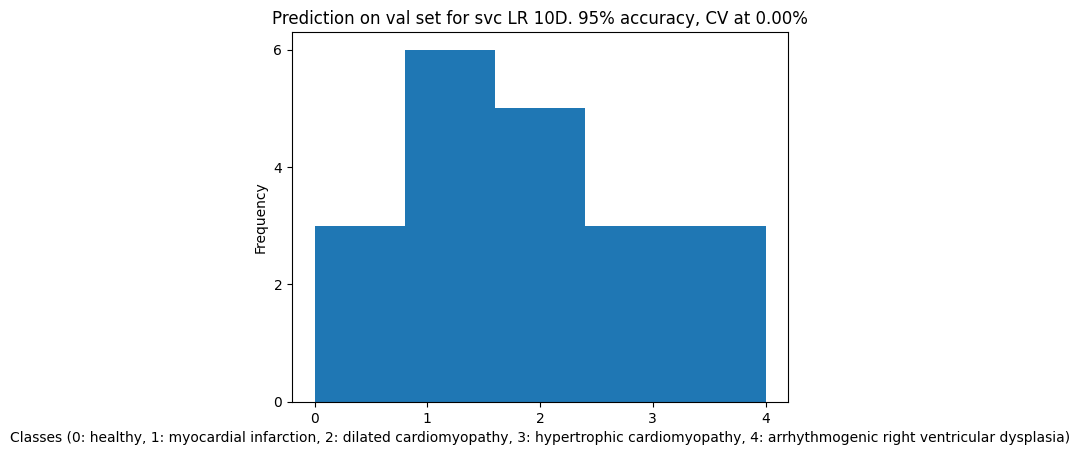

In [33]:
y_val_preds = clf.predict(X_val)

test_accuracy = (y_val_preds == y_val).sum() / len(y_val)

plt.hist(np.array(y_val_preds), bins=5)
plt.xticks([0,1,2,3,4])
plt.yticks([0, 2, 4, 6])
plt.xlabel('Classes (0: healthy, 1: myocardial infarction, 2: dilated cardiomyopathy, 3: hypertrophic cardiomyopathy, 4: arrhythmogenic right ventricular dysplasia)')
plt.ylabel('Frequency')
plt.title("Prediction on val set for svc LR 10D. {:.0f}% accuracy, CV at {:.2f}%".format(test_accuracy*100, 0))

## Now let us test that model on the test dataset

In [34]:
test_features = np.zeros((50, 12))  

In [35]:
test_subject_list1 = load_filled_test_dataset()
test_subject_list = load_test_dataset()

volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []
   
for i in range(0, 50):
    subject1 = test_subject_list1[i]

    subject_ed = test_subject_list[i].ed_seg.data.numpy()[0]
    ed_view = subject1.ed_seg

    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + int((lv_volume(subject_ed == 2)).sum())
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(int((lv_volume(subject_ed == 2)).sum())/sum_volumes)

    subject_es = test_subject_list[i].es_seg.data.numpy()[0]
    es_view = subject1.es_seg

    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + int((lv_volume(subject_es == 2)).sum())
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(int((lv_volume(subject_es == 2)).sum())/sum_volumes)

volumes_1_ed = np.array([volumes_1_ed]).flatten()
volumes_2_ed = np.array([volumes_2_ed]).flatten()
volumes_3_ed = np.array([volumes_3_ed]).flatten()

volumes_1_es = np.array([volumes_1_es]).flatten()
volumes_2_es = np.array([volumes_2_es]).flatten()
volumes_3_es = np.array([volumes_3_es]).flatten()


ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed


ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es


for i, new_col in enumerate([ratioRL_ed[:], ratioRL_es[:], ratioML_ed[:], ratioML_es[:], ejection_fraction_right[:], volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], ejection_fraction_left[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    test_features[:,i] = new_col

test_features = scaler.transform(test_features)

We can now predict

And write down for submission

In [36]:
test_preds = clf.predict(test_features)
test_preds

array([1, 4, 0, 3, 4, 1, 0, 0, 4, 4, 3, 3, 0, 0, 0, 4, 2, 3, 1, 0, 4, 0,
       0, 3, 1, 2, 1, 4, 2, 4, 1, 4, 3, 2, 0, 3, 1, 3, 1, 0, 2, 1, 2, 2,
       4, 2, 0, 1, 1, 1])

In [37]:
df = pd.read_csv("../SampleSubmission.csv")
df.iloc[:, 1] = test_preds
df.to_csv("../SampleSubmission.csv", index=False)